# Example notebook for GreenRoof class
This is an example notebook file to demonstrate the usage of the GreenRoof class which is written in Python and based on the Catchment Modelling Framework (CMF, see https://philippkraft.github.io/cmf/). Please refer to our article which includes the scientifc description of the green roof model.

First, we import all necessary packaes (please make sure that CMF is installed):

In [1]:
from greenroof import GreenRoof
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In order to work with different green roof configurations, we define a function `plot_runoff()`, `plot_head()` and a class `Parameters` for plotting and organizing different parameter sets, respectively:

In [2]:
def plot_runoff(df, obsdata=None, title=None):
    """
    Plots outflow from simulations performed with GreenRoof class

    Parameters
    ----------
    df : pd.DataFrame
        A pandas DataFrame that includes the results from GreenRoof.run() function.
    obsdata : string, optional
        Column name that refers to sampledata.csv. The default is None.

    Returns
    -------
    None.

    """
    # select series from data frame and aggregate to 1 min (from 15s values)
    outflow = df['Darcy flow'].resample('60S', label='right', closed='right').sum()
    outflow_s = df['Surface runoff'].resample('60S', label='right', closed='right').sum()
    outflow_total = outflow + outflow_s # darcy + surface
    # plot
    plt.figure()
    outflow.plot()
    outflow_s.plot()
    outflow_total.plot(label='Total runoff')
    if obsdata is not None:
        obsdata.plot(linestyle='None',marker='+', color='k', label='observed')
    if title is not None:
        plt.title(title)
    plt.xlabel('Time [min]')
    plt.ylabel('Runoff [l/min]')
    plt.legend()
    plt.show()

In [3]:
def plot_head(model, results, t):
    """
    This function plots the distribution of hydraulic head for time step t (as index).

    Parameters
    ----------
    model : GreenRoof
        The object of the GreenRoof model.
    results : pd.DataFrame
        The results obtained through running model.run()
    t : pd.DateTime
        time to be plotted.
    
    Returns
    -------
    None.
    """
    plt.figure()
    plt.fill_between(model.x_dim, model.bottom, facecolor='none', edgecolor='#bdbdbd', hatch='\\\\')
    plt.fill_between(model.x_dim, model.bottom + model.depth, model.bottom, color='#f0f0f0')
    plt.plot(model.x_dim, model.bottom,color='#bdbdbd')
    plt.plot(model.x_dim, model.bottom + model.depth,color='#bdbdbd')
    plt.plot(model.x_dim, results['Water level'].loc[t], label='Hydraulic head (substrate)')
    surf = results['Ponding'].loc[t]
    surf[surf==0]=np.nan # don't display areas without ponding
    plt.plot(model.x_dim, model.bottom + model.depth + surf, label='Ponding (surface)')
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
    plt.legend()
    plt.title('Green roof with %.1f%% slope @t=%s' % (model.slope*100, str(t)))

In [4]:
class Parameters:
    def __init__(self, length,slope,d_init,observation=None):
        """
        This class represents the most important green roof parameters
        for the GreenRoof class.

        Parameters
        ----------
        length : float
            Length of green roof [m].
        slope : float
            Slope as fraction, e.g., 0.02 means 2%.
        d_init : float
            Delta in matric potantial [m].
        observation : string, optional
            Column name in sampledata.csv with observed data. The default is None.

        Returns
        -------
        None.

        """
        self.length=length
        self.slope=slope
        self.rheigth=length*slope
        self.d_init=d_init
        self.obs=observation

Moreover, we define two green roof configurations (0% and 2% with different initial conditions) and the boundary conditions (meteorological forcing):

In [5]:
gr0 = Parameters(20., 0.00, 0.15, 'obs0')
gr2 = Parameters(20., 0.02, 0.30, 'obs2')

rainfall = 27 # mm
duration = 15 # minutes

The sequence of parameters is: (1) length, (2) slope, (3) delta in initial potential, and (4) the column heading in the file which contains measured time series (see below). For these green roof configurations and the design rainfall defined here, we have got corresponding observed runoff time series (credit: Daniel Westerholt):

In [6]:
obsdata = pd.read_csv('data/sampledata.csv',index_col=0, parse_dates=[0])

Now, we iterate over both configurations in a loop in which the model is called with the corresponding parameters and plots are shown. This may take some seconds....

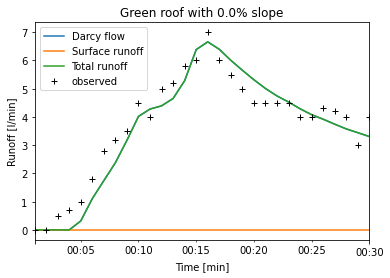

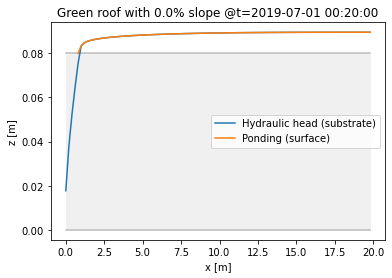

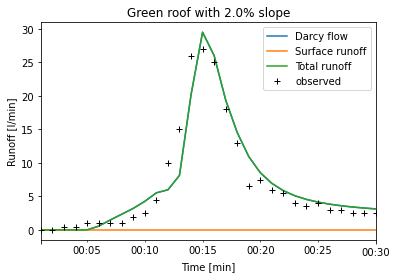

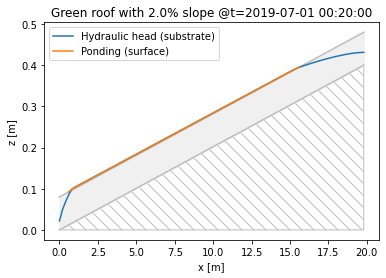

In [7]:
list_runs = [gr0,gr2]

for run in list_runs:
    # obersvations (set to None if not available)
    observations = obsdata[run.obs]
    
    # define model        
    model = GreenRoof(rheight=run.rheigth, length=run.length,
                      nl=5, ksat=1750, porosity=0.5,
                      mannings_n=0.08, b=5.5, duration=30,
                      d_init_pot=run.d_init)
    
    # activate rainfall forcing
    model.set_design_rain(rain_duration=duration, rain_amount=rainfall)
        
    # run the model (may take some time) and plot results
    results = model.run()
    plot_runoff(results, observations,'Green roof with %.1f%% slope' % (run.slope*100) )
    plot_head(model, results, '2019-07-01 00:20:00')

The results show that the hydrological response is higher for the 2% green roof in terms of peak discharge. Moreover, the hydraulic head along the x axis also shows clear differences related to the green roof's slope. The non-declined configuration has one single minimum of hydraulic head near the outlet (left side), while the 2% setup shows another minimum at the top. Ponding in combination with surface runoff suggests an effective redistribution of water.